# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=500, init_abundance=50, dt=1,
             sigma_env_trait=0.3, mut_prob=0.005, sigma_mut=0.05, sigma_mov=0.12,
             random_seed=1234, taxon_threshold=0.05, taxon_def='traits'):
    """
    Main function to compute one of the two speciation models
    
    Parameters
    ----------
    
    trait_comp: bool, 
                If False it will compute the speciation model without 
                competition (Irwin 2012 Am. Nat.) or if True the model 
                with competition (Doebeli & Dieckmann 2003 Nature).
    num_gen: int
             maximum number of generations to compute.
    init_abundance: int
                    initial number of individuals.
    dt: float
        time step of the simulation
    sigma_env_trait: float
                     enviromental fitness variability.
    mut_prob: float
              mutation probability.
    sigma_mut: float
               trait variability of mutated offspring.
    sigma_mov: float
               dispersal variability of offspring. The spatial extend to disperse is normalize 
               to 0 and 1 thus the value should be between 0 to 1.
    random_seed: int
                 seed of the random number generator
    taxon_threshold: float
                     threshold value to separate taxa in the spectral clustering algorithm.
    taxon_def: str
               If 'traits' taxon are defined as sharing common ancestry and similar trait values
               or if 'traits_location' spatial location is in addition to the previous variables
               included into the clustering algorithm.
    """
    #build a static landscape with single gradient along the x coordinate
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(random_seed)
    environment = X + r.rand(*Y.shape)
    # Initialize traits and environmental fields for speciation models
    # First we initialize one trait associated with elevation where the 
    # initial min/max provides the range of trait values that the individual 
    # will have and where the slope determines the linear relationship between
    # environmental field and the optimal trait value for each individual on that field.
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    # define one of the two types speciation models
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, init_abundance,
                                    car_cap_max=500, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    sigma_comp_trait=0.9, sigma_comp_dist=0.19, taxon_threshold=taxon_threshold, 
                                    taxon_def=taxon_def)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, init_abundance, 
                                    nb_radius=50, car_cap=50, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    taxon_threshold=taxon_threshold, taxon_def=taxon_def)
    print(model)
    # initialize the model
    model.initialize()
    dfs = []
    # main loop to execute and store model resutls
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, environment, X):
    """
    Plot solution of the model result.
    
    Parameters
    ----------
    dtf: pd.DataFrame
         with results of the speciation model
    environment: array-like
                 environmental field
    X: array-like
       x coordinate
    """
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    axs1_2 = axs1[0,0].twinx()
    axs1_2.plot(dtf.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
    
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(environment)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')
    axs1_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1 and trait_values.std() / trait_values.mean() > 1e-10:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 100)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    nb_radius: 50
    car_cap: 50
    sigma_env_trait: 0.3
    sigma_mov: 0.12
    sigma_mut: 0.05
    mut_prob: 0.005



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,134.141559,1.0,0.0,3,0.321134,0.5000
1,0,0.0,0.0,95.048934,183.307913,1.0,0.0,9,0.932762,0.5000
2,0,0.0,0.0,230.811558,112.227697,1.0,0.0,4,0.405857,0.5000
3,0,0.0,0.0,65.423106,76.375192,1.0,0.0,3,0.751546,0.5000
4,0,0.0,0.0,79.774265,236.839901,1.0,0.0,11,0.849979,0.5000
...,...,...,...,...,...,...,...,...,...,...
222273,499,499.0,0.0,140.116810,236.407257,1895.0,1893.0,1,0.469689,0.1896
222274,499,499.0,0.0,67.002909,234.780037,1895.0,1893.0,1,0.956651,0.1896
222275,499,499.0,0.0,1.178201,161.271510,1895.0,1893.0,1,0.870539,0.1896
222276,499,499.0,0.0,21.594293,73.879813,1895.0,1893.0,1,0.965816,0.1896


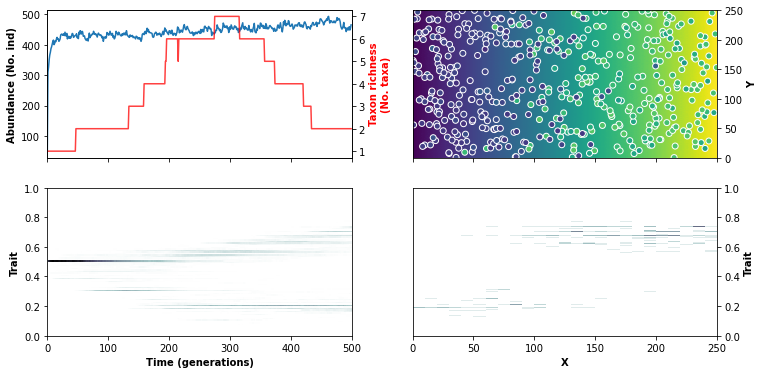

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1.loc[taxon_lineage1.time==499].taxon_id.to_list()

['1895', '1896']

In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [10]:
tree1.print_plot()

                               /++++++++++++++++++++++++++++++++++++++++++ 1895
                   +++++++++++++                                               
                   |           \------------------++++++++++++++++++++++++ 1534
      ++++++++++++++                                                           
      |            |                              /-----++++++++++++++++++ 1202
      |            |               /--------+++++++                            
      |            \-----------+++++              ++++++++++++++++++++++++ 1449
+++++++                            |                                           
      |                            +++++++++++++++++++++++++++++++++++++++ 1723
      |                                                                        
      |                     /------------------------------------------+++ 559 
      +++++++++++++++++++++++                                                  
                            |           

### Tree of only extant taxa 

In [11]:
extant_taxon = (taxon_lineage1.loc[taxon_lineage1.time==499].taxon_id.to_list())
extant_taxon.insert(0,0)
extant_taxon

[0, '1895', '1896']

In [12]:
toytree_plot(tree1.extract_tree_with_taxa_labels(extant_taxon), ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tedabccb8de7143bbb0a5c1225ba7f76d"> <polygon points="200.0,200.0 201.53061224489795,200.0 203.0612244897959,200.0 204.59183673469389,200.0 206.12244897959187,200.0 207.6530612244898,200.0 209.18367346938774,200.0 210.71428571428572,200.0 212.24489795918367,200.0 213.77551020408163,200.0 215.30612244897958,200.0 216.83673469387753,200.0 218.36734693877548,200.0 219.8979591836735,200.0 221.42857142857144,200.0 222.9591836734694,200.0 224.48979591836735,200.0 226.0204081632653,200.0 227.55102040816325,200.0 229.0816326530612,200.0 230.61224489795916,200.0 232.1428571428571,200.0 233.6734693877551,200.0 235.20408163265304,200.0 236.73469387755102,200.0 238.26530612244898,200.0 239.79591836734693,200.0 241.3265306122449,200.0 242.85714285714286,200.0 244.3877551020408,200.0 245.91836734693877,200.0 247.44897959183675,200.0 248.9795918367347,200.0 250.51020408163265,200.0 252.0408163265306,200.0 253.57142857142858,200.0 255.10204081632654,200.0 256.6326530612245,200.0 258.16326530612247,200.0 259.6938775510204,200.0 261.2244897959184,200.0 262.7551020408163,200.0 264.2857142857143,200.0 265.81632653061223,200.0 267.3469387755102,200.0 268.8775510204082,200.0 270.4081632653061,200.0 271.9387755102041,200.0 273.469387755102,200.0 275.0,200.0 275.0,200.0 273.469387755102,200.0 271.9387755102041,200.0 270.4081632653061,200.0 268.8775510204082,200.0 267.3469387755102,200.0 265.81632653061223,200.0 264.2857142857143,200.0 262.7551020408163,200.0 261.2244897959184,200.0 259.6938775510204,200.0 258.16326530612247,200.0 256.6326530612245,200.0 255.10204081632654,200.0 253.57142857142858,200.0 252.0408163265306,200.0 250.51020408163265,200.0 248.9795918367347,200.0 247.44897959183675,200.0 245.91836734693877,200.0 244.3877551020408,200.0 242.85714285714286,200.0 241.3265306122449,200.0 239.79591836734693,200.0 238.26530612244898,200.0 236.73469387755102,200.0 235.20408163265304,200.0 233.6734693877551,200.0 232.1428571428571,200.0 230.61224489795916,200.0 229.0816326530612,199.9999999999979 227.55102040816325,199.99999861207056 226.0204081632653,199.98600695805786 224.48979591836735,197.7861748267005 222.9591836734694,190.2810173714248 221.42857142857144,189.41681759312692 219.8979591836735,192.18355219944496 218.36734693877548,182.31491255660455 216.83673469387753,158.51294733641544 215.30612244897958,12.5 213.77551020408163,29.688237909694838 212.24489795918367,101.9348112456492 210.71428571428572,189.7990570741287 209.18367346938774,197.58960376321733 207.6530612244898,199.95023752188166 206.12244897959187,199.99997905486427 204.59183673469389,199.9999999998593 203.0612244897959,200.0 201.53061224489795,200.0 200.0,200.0" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(100%,100%,100%);stroke-opacity:1.0;stroke-width:0.5"> 1895 <polygon points="200.0,350.0 201.53061224489795,350.0 203.0612244897959,350.0 204.59183673469389,350.0 206.12244897959187,350.0 207.6530612244898,350.0 209.18367346938774,350.0 210.71428571428572,350.0 212.24489795918367,350.0 213.77551020408163,350.0 215.30612244897958,350.0 216.83673469387753,350.0 218.36734693877548,350.0 219.8979591836735,350.0 221.42857142857144,350.0 222.9591836734694,350.0 224.48979591836735,350.0 226.0204081632653,350.0 227.55102040816325,350.0 229.0816326530612,350.0 230.61224489795916,350.0 232.1428571428571,350.0 233.6734693877551,350.0 235.20408163265304,350.0 236.73469387755102,350.0 238.26530612244898,350.0 239.79591836734693,350.0 241.3265306122449,350.0 242.8

### Tree summary statistics 

Phylogenetic diversity (PD)

In [13]:
sum(tree1.calc_node_root_distances())

3109.0

In [14]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [15]:
pdm1.mean_pairwise_distance()

571.9642857142857

Mean neighbor taxon distance (MNTD)

In [16]:
pdm1.mean_nearest_taxon_distance()

336.75

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

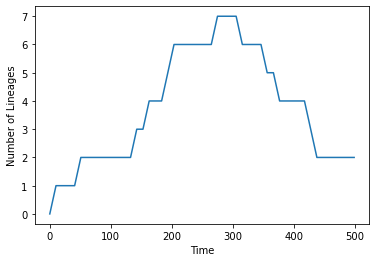

In [17]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [18]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    birth_rate: 1
    car_cap_max: 500
    sigma_env_trait: 0.3
    mut_prob: 0.005
    sigma_mut: 0.05
    sigma_mov: 0.12
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.19



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [19]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,death_i,trait_0
0,0,0.0,0.0,244.174942,134.141559,1.0,0.0,5,0.321134,0.197122,0.500000
1,0,0.0,0.0,95.048934,183.307913,1.0,0.0,48,0.932762,0.081075,0.500000
2,0,0.0,0.0,230.811558,112.227697,1.0,0.0,6,0.405857,0.172303,0.500000
3,0,0.0,0.0,65.423106,76.375192,1.0,0.0,8,0.751546,0.129093,0.500000
4,0,0.0,0.0,79.774265,236.839901,1.0,0.0,0,0.849979,0.072511,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
272274,499,499.0,0.0,224.703842,54.798469,1977.0,1974.0,1,0.989306,0.831779,0.924248
272275,499,499.0,0.0,222.084039,100.311079,1977.0,1974.0,1,0.981921,0.834833,0.924248
272276,499,499.0,0.0,223.693379,213.325393,1977.0,1974.0,0,0.987247,0.661337,0.924248
272277,499,499.0,0.0,223.443716,110.268167,1977.0,1974.0,0,0.983798,0.815804,0.924248


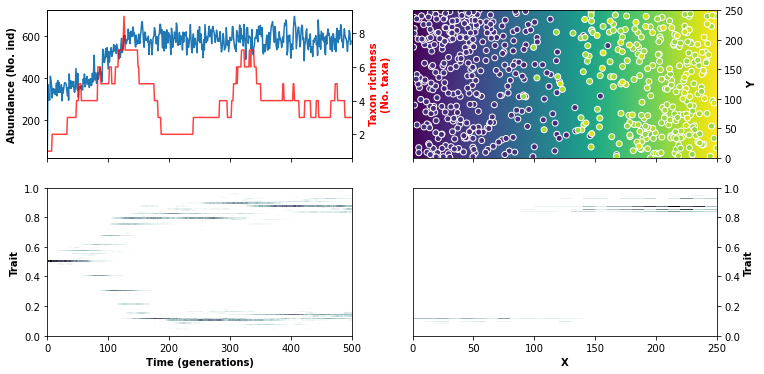

In [20]:
plot_sol(ind_dtf2, elevation2, X2)

In [21]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,50,root
1,1.0,2,1,0.500098,369,node
2,2.0,3,2,0.500060,295,node
3,3.0,4,3,0.500350,303,node
4,4.0,5,4,0.499995,295,node
...,...,...,...,...,...,...
1974,498.0,1975,1972,0.859345,227,node
1975,498.0,1976,1973,0.137020,281,node
1976,499.0,1977,1974,0.931680,42,leaf
1977,499.0,1978,1975,0.859015,225,leaf


In [22]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [23]:
tree2.print_plot()

                  /------------------------------------------------------+ 496 
                  |                                                            
                  |       /---------------------------------------------++ 833 
                  |       |                                                    
                  |       |                  /---------------------------- 1181
                +++       |                  +                                 
                | |       |                  |/---------------------++++++ 1420
                | |       |                  |+                                
                | |       |                  ||/-------------+++++++++++++ 1644
                | |       |                  |++                               
                | +++++++++                 ++ +++++++++++++++++++++++++++ 1977
                |         |                 ||                                 
                |         |             

### Tree of only extant taxa 

In [24]:
extant_taxon2 = (taxon_lineage2.loc[taxon_lineage2.time==499].taxon_id.to_list())
extant_taxon2.insert(0,0)
extant_taxon2

[0, '1977', '1978', '1979']

In [25]:
toytree_plot(tree2.extract_tree_with_taxa_labels(extant_taxon2), ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6228b7f9553d496e99031218b416ce1f"> <polygon points="200.0,150.0 201.53061224489795,150.0 203.0612244897959,150.0 204.59183673469389,150.0 206.12244897959187,150.0 207.6530612244898,150.0 209.18367346938774,150.0 210.71428571428572,150.0 212.24489795918367,150.0 213.77551020408163,150.0 215.30612244897958,150.0 216.83673469387753,150.0 218.36734693877548,150.0 219.8979591836735,150.0 221.42857142857144,150.0 222.9591836734694,150.0 224.48979591836735,150.0 226.0204081632653,150.0 227.55102040816325,150.0 229.0816326530612,150.0 230.61224489795916,150.0 232.1428571428571,150.0 233.6734693877551,150.0 235.20408163265304,150.0 236.73469387755102,150.0 238.26530612244898,150.0 239.79591836734693,150.0 241.3265306122449,150.0 242.85714285714286,150.0 244.3877551020408,150.0 245.91836734693877,150.0 247.44897959183675,150.0 248.9795918367347,150.0 250.51020408163265,150.0 252.0408163265306,150.0 253.57142857142858,150.0 255.10204081632654,150.0 256.6326530612245,150.0 258.16326530612247,150.0 259.6938775510204,150.0 261.2244897959184,150.0 262.7551020408163,150.0 264.2857142857143,150.0 265.81632653061223,150.0 267.3469387755102,150.0 268.8775510204082,150.0 270.4081632653061,150.0 271.9387755102041,150.0 273.469387755102,150.0 275.0,150.0 275.0,150.0 273.469387755102,150.0 271.9387755102041,150.0 270.4081632653061,150.0 268.8775510204082,150.0 267.3469387755102,150.0 265.81632653061223,150.0 264.2857142857143,150.0 262.7551020408163,150.0 261.2244897959184,150.0 259.6938775510204,150.0 258.16326530612247,150.0 256.6326530612245,150.0 255.10204081632654,150.0 253.57142857142858,150.0 252.0408163265306,150.0 250.51020408163265,150.0 248.9795918367347,150.0 247.44897959183675,150.0 245.91836734693877,150.0 244.3877551020408,150.0 242.85714285714286,150.0 241.3265306122449,150.0 239.79591836734693,150.0 238.26530612244898,150.0 236.73469387755102,150.0 235.20408163265304,150.0 233.6734693877551,150.0 232.1428571428571,150.0 230.61224489795916,150.0 229.0816326530612,150.0 227.55102040816325,150.0 226.0204081632653,150.0 224.48979591836735,150.0 222.9591836734694,150.0 221.42857142857144,150.0 219.8979591836735,150.0 218.36734693877548,150.0 216.83673469387753,150.0 215.30612244897958,149.9999999563097 213.77551020408163,149.23143054815657 212.24489795918367,146.17016376157443 210.71428571428572,25.000000000000025 209.18367346938774,115.37585907729766 207.6530612244898,135.60286474087684 206.12244897959187,149.04454004054622 204.59183673469389,149.99983742514382 203.0612244897959,150.0 201.53061224489795,150.0 200.0,150.0" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(100%,100%,100%);stroke-opacity:1.0;stroke-width:0.5"> 1979 <polygon points="200.0,250.00000000000003 201.53061224489795,250.00000000000003 203.0612244897959,250.00000000000003 204.59183673469389,250.00000000000003 206.12244897959187,250.00000000000003 207.6530612244898,250.00000000000003 209.18367346938774,250.00000000000003 210.71428571428572,250.00000000000003 212.24489795918367,250.00000000000003 213.77551020408163,250.00000000000003 215.30612244897958,250.00000000000003 216.83673469387753,250.00000000000003 218.36734693877548,250.00000000000003 219.8979591836735,250.00000000000003 221.42857142857144,250.00000000000003 222.9591836734694,250.00000000000003 224.48979591836735,250.00000000000003 226.0204081632653,250.00000000000003 227.55102040816325,250.00000000000003 229.0816326530612,250.00000000000003 230.61224489795916,250.00000000000003 23

### Tree summary statistics 

Phylogenetic diversity (PD)

In [26]:
sum(tree2.calc_node_root_distances())

8585.0

In [27]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [28]:
pdm2.mean_pairwise_distance()

393.0827586206897

Mean neighbor taxon distance (MNTD)

In [29]:
pdm2.mean_nearest_taxon_distance()

61.43333333333333

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

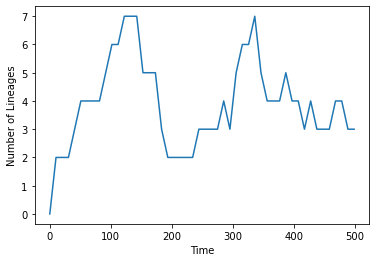

In [30]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')